# Customer Data Aanlysis

### -- Analysis and Modeling on a credit card customer dataset for business insights.

## Table of Content.

- Notebook I: Data Cleaning and EDA.


- Notebook II: Churn Prediction.
         
         
- Notebook III: Customer Segementation.


- Notebook IV: Custermer Lifetime Value Analysis.

# This is Notebook II : Churn Prediction.

 -- In this Notebook, we build machine learning classifiers to predict Customer Churn. 

 -- Customer Churn Rate is a measurement about how many customers stop using a product. Accuarte Prediction of which customer will churn (i.e. stop using a product) is the key to successful business strategy.
 
 -- We train RandomForest and XGBoost models to predict Customer Churn. 
 
 -- Our best model reports a 98% recall and a 99% f1 scores on test set.

## Sections in this Notebook:

0. Data Loading.     
    
     
1. More Problem-specific EDA. 


2. Data Preprocessing.

        2.1 Train-Validation-Test split
        
        2.2 Upsampling

3. Classifiers for Churn Prediction.

 
        3.1 RandomForest.
        
        3.2 XGBoost: a tree-based boosting classifier.
        
        
        
    
4. Further Question: Churn Probability.
        
        To-do: Logistic Model for Churn probabity.

In [60]:
# This is Python 3 environment, with Anaconda distribution of several helpful standard libraries.
# Additional modules/packages may needed: pickle, xgboost, helper_functions(self-defined in this repository).

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.utils import resample

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb



## 0. Data Loading.

In [3]:
# Data was processed in Notebook 1 and saved in a pickle file.
# Grab the processed data from the pickle file.

with open('1_data_after_notebook1.pkl', 'rb') as pickle_file:
    df = pickle.load(pickle_file)
    
df

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Divorced,Married,Single,Unknown,ClientNum_Cluster
0,0,45,0,3,1.000000,3.0,1,39,5,1,...,1.335,1144,42,1.625,0.061,0,1,0,0,1
1,0,49,1,5,3.000000,1.0,1,44,6,1,...,1.541,1291,33,3.714,0.105,0,0,1,0,1
2,0,51,0,3,3.000000,4.0,1,36,4,1,...,2.594,1887,20,2.333,0.000,0,1,0,0,0
3,0,40,1,4,1.000000,1.0,1,34,3,4,...,1.405,1171,20,2.333,0.760,0,0,0,1,1
4,0,40,0,3,0.000000,3.0,1,21,5,1,...,2.175,816,28,2.500,0.000,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,0,2,3.000000,2.0,1,40,3,2,...,0.703,15476,117,0.857,0.462,0,0,1,0,1
10123,1,41,0,2,2.061106,2.0,1,25,4,2,...,0.804,8764,69,0.683,0.511,1,0,0,0,0
10124,1,44,1,1,1.000000,1.0,1,36,5,3,...,0.819,10291,60,0.818,0.000,0,1,0,0,0
10125,1,30,0,2,3.000000,2.0,1,36,4,3,...,0.535,8395,62,0.722,0.000,0,0,0,1,0


## 1. More Specific EDA for Churn Prediction. 

### 1.1 Examine the churn rate in the dataset.

Note: the target column is 'Attrition_Flag', 0 represents Customer Stay, 1 means Customer Churn.

### Conclusion: the dataset is imbalance, as the analysis below shows. 

We'll have to address this when later in data preprocessing.

In [16]:
# bar plot of the target/dependent variable

churn_counts = pd.DataFrame(df.Attrition_Flag.value_counts())

churn_counts

,Attrition_Flag
0,8500
1,1627


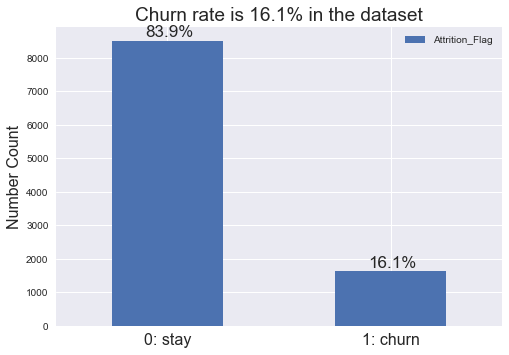

In [17]:
churn_rate = df.Attrition_Flag.mean()

churn_counts.plot(kind='bar')
plt.xticks(range(2),['0: stay', '1: churn'], rotation='horizontal', fontsize= 16)
plt.ylabel('Number Count', fontsize= 16)
for x, y in churn_counts.iterrows():
    plt.text(x-.1, y+120, f'{round(abs(abs(1-x)-churn_rate)*100, 1)}%',  fontsize=17)
plt.title(f'Churn rate is {round(churn_rate*100,1)}% in the dataset', fontsize =19)
plt.show()

### 1.2 Examine the relation between indivisual features and the target 'Attrition_Flag'.

In Notebook 1, we saw in a pairplot that the following features have the most distinguishable relations with 'Attrition_Flag'.

In [12]:
# features have the most visible relations with the target from Notebook 1 EDA.

key_features = ['Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1']

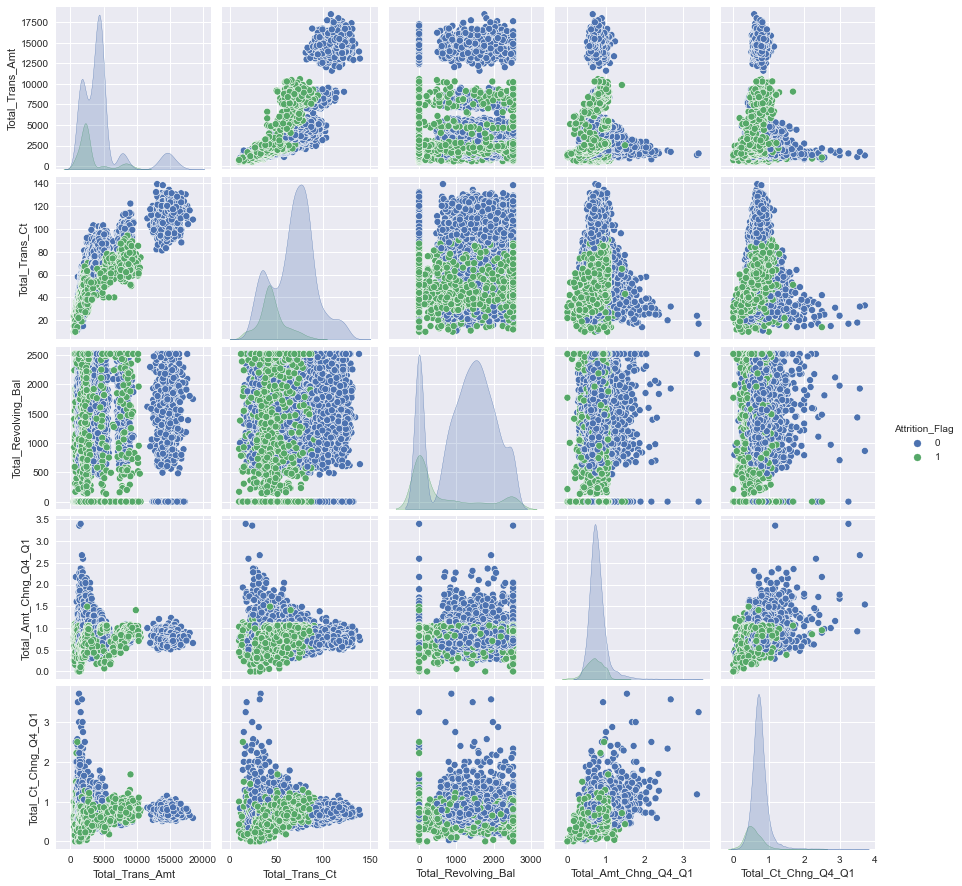

In [13]:
# pairplot with hue
sns.pairplot(df[key_features + ['Attrition_Flag']], hue='Attrition_Flag');

### 1.3 Examine feature dependence

In Notebook 1, we notice that the following pairs of features have strong correlation.

    - ('Customer_Age', 'Months_on_book')**
    
    - (total_trans_amt, total_trans_ct)
    
    - (total_revolving_bal, avg_ultilization)
    
    - (credit limit, income_cat/card_cat)
    
    - (income category, gender)***




** We also note that while 'Age' has a basically normal distribution,

'Months_On_Book' has a somewhat stange distribution that is likely due to missing data filling (done before we get the dataset).


*** Even though 'income_category' and 'gender' has very strong correlation in this dataset, but by common sense these two variables should be relatively independent。

### 1.3 Observations: 

#### (a). The dependence between these pairs if we  train a good Naive Bayes model.

 - ('Customer_Age', 'Months_on_book')
    
 - (total_trans_amt, total_trans_ct)
    
 - (total_revolving_bal, avg_ultilization)
    
 - (credit limit, income_cat/card_cat)
  
  

#### (b). We could use 'Age' to re-impute 'Months_On_Book'.

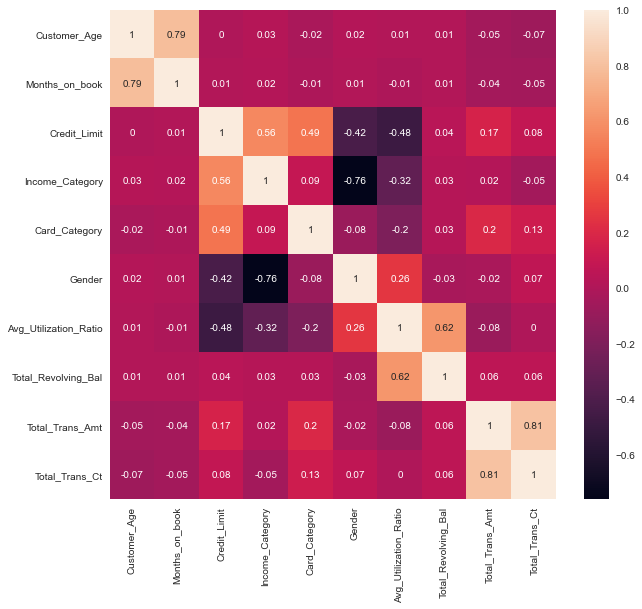

In [77]:
# related features to exam
related_features = ['Customer_Age','Months_on_book','Credit_Limit', 'Income_Category', 'Card_Category', 'Gender',
                    'Avg_Utilization_Ratio', 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct']

# correlation matrix
dims = (10, 9)
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(df[related_features].corr().round(2), annot=True);

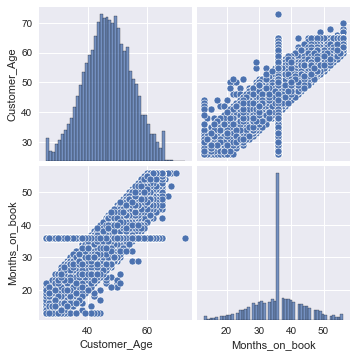

In [74]:
# pairplot btw 'Customer_age' and 'Months_on_book'

sns.pairplot(df[['Customer_Age', 'Months_on_book']]);

## 2. PCA.

Principal Components Analysis (PCA) is an important Dimension Reduction technique in Machine Learning.

PCA is commonly used to reduce the number of features in a dataset before training a model, to overcome problems like overfitting. 

This is because PCA can identify the most influential (eigen-)directions/components in our high dimension data space, we can select the appropriate number of components to train predictive model, and strike a balance between variance of data and variance of the model.

In [4]:
# we wrote a function Perform_PCA to perform Standarization and PCA for a given dataframe
# we save the function in helper_functions.py to recycle here

# import helper function Perform_PCA 
from helper_functions import Perform_PCA

#For more info about the function, see
#Perform_PCA?

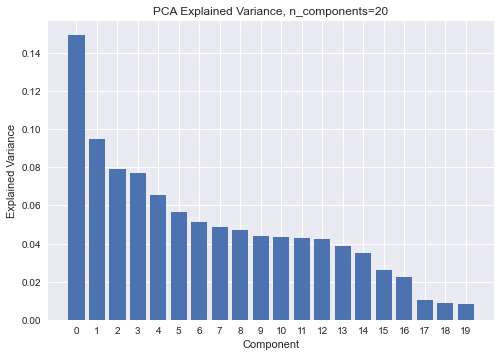

The total explained variance by the 20 components is 0.9929121909152006


In [5]:
# Peform_PCA do PCA transform to df, it will return (df_components, pca), 
# where df_components: a dataframe saving the components of the PCA.
# It also out a plot of explained variance of each components.

df_pca, pca = Perform_PCA(df.drop('Attrition_Flag',axis=1), n_components=20)

In [6]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.888329,-1.583116,-1.264832,2.157431,1.766440,3.944395,0.308485,-0.262704,-0.283268,0.561332,0.747779,0.223389,-1.456736,0.949228,0.293323,1.032534,0.206877,0.375765,0.303537,0.150711
1,-0.870718,0.879201,-0.571202,2.207326,5.575079,9.528520,1.305061,1.160361,-1.329671,2.582652,-0.452867,1.880372,-0.320288,2.711635,0.395145,6.212503,0.287149,0.820460,0.105607,-0.169013
2,0.284328,-0.887163,-1.883952,4.161232,3.719698,9.190242,0.591531,-0.866215,-0.587242,0.978583,-1.987890,0.283751,0.857205,0.952861,2.511827,-1.016146,1.066975,-0.147647,-0.551857,-0.264270
3,-2.350035,0.949882,-1.554418,2.551658,4.076908,3.776050,3.591862,0.730229,-3.151347,-0.032062,1.281419,2.397493,1.148466,-0.023326,2.305655,2.770696,-0.040489,0.458523,0.081981,-0.045829
4,0.089702,-0.204384,-3.823538,3.452422,3.425081,8.547314,0.469056,-0.760243,-0.444243,-0.510258,-1.652860,1.400617,-0.545898,0.097848,1.719937,0.829984,1.070532,0.078556,-0.710411,0.253989


## 2. Preprocessing.

Because the data to be classified are imbalanced, we shall upsample the minor class (churn).

Before that, we should split the training and test sets, then only upsample the training part and leave the test set intact.



### 2.1 Train-Validation-Test split

In [7]:
 # select X, y from the given data
target = 'Attrition_Flag'
y=df[target].values
X=df.drop(target, axis=1).values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

# train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=17)


### 2.2 Upsampling imbalanced training set

In [8]:
# mask 
df_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train, columns=['Attrition_Flag'])], axis=1)

In [9]:
# class stay (Attirtion_Flag = 0) in train set
df_stay = df_train[df_train[target]==0]
# class churn (Attirtion_Flag = 1) in train set
df_churn = df_train[df_train[target]==1]

# resample X_churn with replacement
df_churn_upsample = resample(df_churn, replace=True, n_samples=len(df_stay), random_state=57)

df_upsample = pd.concat([df_stay, df_churn_upsample])

y_train = df_upsample[target].values
X_train = df_upsample.drop(target, axis=1).values

In [10]:
X_train.shape

(10216, 23)

## 3. Churn Prediction Models


In the section, we train a logistic model with upsampling, penalized SVM, RandomForest, XGBoost, and Naive Bayes classifiers for our prediction task.

In [11]:
# train_tune_score is a helper function that performs: 
# 1. n-fold cross validation on training set to determine the best hyperparameter(s),
# 2. fit model with the training set,
# 3. then reports the scores and confusion matrix, return trained model and train, test sets.

from helper_functions import train_tune_score

In [12]:
# more info about train_tune_score see
train_tune_score?

### Choosing an appropriate metric.

First of all, we should think about the scalar score(s) we want to use to evaluate our models. 
 
In the case of classification with such an imbalanced target, the accuracy score is often not a good choice. A silly baseline model, where we simply predict the prevalent value for every test data point, will already have high accuracy. Therefore, accuracy score often lack the capacity to fully showcase the strength of each model.

A better choice in this case is the f1_score, which combines precision and recall in a parallel-circuit way. As shown in the below, the f1 score for the silly baseline model is 0 while accuracy for that is 0.84. 

#### Therefore, we will use f1_score to validate and evaluate our models.

#### We will also use non-scalar evaluations such as Confusion Matrix and ROC curve for more comprehensive analysis.

In [13]:
target = 'Attrition_Flag'
y=df[target].values
X=df.drop(target, axis=1).values
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=57)

# baseline accuracy
baseline_accuracy = accuracy_score(y_test,np.zeros_like(y_test))

# baseline f1_score
baseline_f1 = f1_score(y_test,np.zeros_like(y_test))

# baseline confusion matrix
baseline_conf_matrix = confusion_matrix(y_test,np.zeros_like(y_test))

print(f'Baseline model accuaracy score is {baseline_accuracy}.')
print(f'Baseline model f1 score is {baseline_f1}.')
print('Baseline model confusion matrix:')
print(baseline_conf_matrix)

    

Baseline model accuaracy score is 0.8400789733464955.
Baseline model f1 score is 0.0.
Baseline model confusion matrix:
[[2553    0]
 [ 486    0]]


In [14]:
tnc = 0
fpc = -50
fnc = -1000
tpc = 0

cost_matrix = np.array([[tnc, fpc],[fnc,tpc]])

def cost(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    return np.sum(cost_matrix*conf_matrix)/np.sum(conf_matrix)

cost_scorer = make_scorer(cost)

In [15]:
tnc = 0
fpc = 50
fnc = 1000
tpc = 100

cost_matrix = np.array([[tnc, fpc],[fnc,tpc]])


def weighted_f1(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    wt_conf_matrix = cost_matrix * conf_matrix
    wt_precision = wt_conf_matrix[1][1]/(wt_conf_matrix[1][1]+wt_conf_matrix[0][1])
    wt_recall = wt_conf_matrix[1][1]/(wt_conf_matrix[1][1]+wt_conf_matrix[1][0])
    
    return 2/(1/wt_precision + 1/wt_recall)
    
wt_fl_scorer = make_scorer(weighted_f1)

From this baseline confusion matrix, let's remember that the upper-left is the True Negative (actual=0, predict=0), lower-left is the False Positive (actual = 1, predict=0), and so on.

A better model will have higher numbers on the diagonal of the confusion matrix, and lower on the other two spots.

### 3.1 Random Forest.

We train a random forest model using the customized weighted f1 score.

Scores on the validation set:

- Recall : 88.1%
- F1_score: 92.9%


In [22]:
# instantiate a Random Forest model
random_forest = RandomForestClassifier()

data = (X_train, X_val, y_train, y_val)

Decision trees and therefore Random Forest tend to overfit if not given tree growing constraints.

We can use for example the following parameters to regularize our model and fight overfitting:

- max_depth: the maximal depth of each decision tree. 

- min_impurity_decrease: if a split results in less impurity decrease than this threshold, it will not be performed.

Both these two should prevent tree growing too large. We found the parameters below give the best results (among all parameters that we manually tried). 

In [41]:
# hyperparameters for random forest model. 

params = {'n_estimators': [60, 70, 80], 'max_depth':[12], 'min_impurity_decrease':[0.0001]}

# train and validate
model_forest = train_tune_score(random_forest, parameters=params, data=data, target='Attrition_Flag', scoring = wt_fl_scorer)

The (best_params, best_score) are: {'max_depth': 12, 'min_impurity_decrease': 0.0001, 'n_estimators': 80} 0.37546312336248583
F1_score on test set is: 0.9291338582677166
Recall on test data:0.8805970149253731
Confusion Matrix:
[[1686    5]
 [  40  295]]


We observe that if we increase max_depth or decrease min_impurity_decrease we can get even better scores, but that's clearly overfitting as we can see by comparing the train and test scores. So these are parameters are by far the best we can get, without obviously overfitting the model.


Next, we shall examine the feature importances according to our random forest model.

(Because later we want to train a logistic model, understanding the feature importance here should be helpful to do feature engineering for our logistic model.)

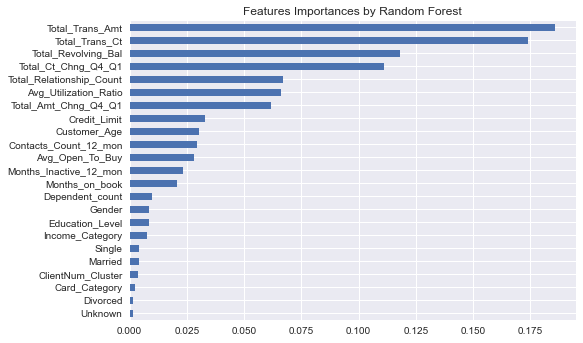

In [42]:
# feature importance according to the random forest model.
feat_importances = pd.Series(model_forest.feature_importances_, index=[x for x in df.columns if x!=target])
feat_importances.sort_values().plot(kind='barh')
plt.title("Features Importances by Random Forest")
plt.show()

### 3.2 XGBoost: Extreme Gradient Boost Model .

We tune and train a XGBoost model using the weighted f1 score we defined.

Score on the validation set:

- Recall: 98.5%

- F1 score: 99.0%

- Accuracy: 99.6%

In [17]:
# instantiate an XGBClassifier
xgboost = xgb.XGBClassifier()

When training a boosting model like xgboost, the first pair of parameters we need to tune are number of estimators and learning rate.

We shall also use 'max_depth' = 6 as a regularization to prevent overfitting.

In [18]:
# parameters to try
params = {'n_estimators': [50,100,200], 'max_depth':[6], 'learning_rate':[1,0.5,0.1], 'random_state':[57]}

# train and validate
model_xgb = train_tune_score(xgboost, parameters=params, data=data, target='Attrition_Flag', scoring = wt_fl_scorer)

The (best_params, best_score) are: {'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 100, 'random_state': 57} 0.5885341737996959
F1_score on test set is: 0.9895052473763117
Recall on test data:0.9850746268656716
Confusion Matrix:
[[1689    2]
 [   5  330]]


Wow! The scores are already amazing without any more tuning!

Besides the incredible power of the xgboost method, the use of a customized metric 'wt_f1_score' also adds an edge to this result.

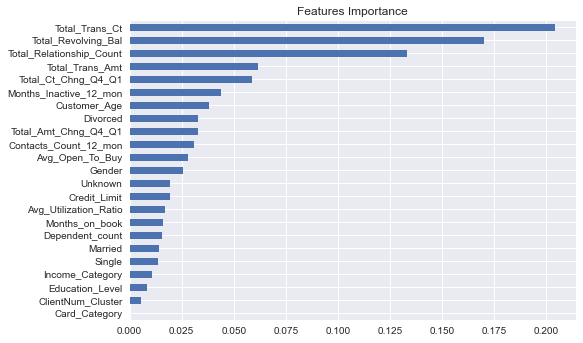

In [19]:
# feature importance according to the random forest model.
feat_importances = pd.Series(model_xgb.feature_importances_, index=[x for x in df.columns if x!=target])
feat_importances.sort_values().plot(kind='barh')
plt.title("Features Importance by XGBoost")
plt.show()

## 4. Further question: Churn Probability.

Even though we already got extremely well-performed tree-based models, we still want to train a logistic model.

One important reason is that a logistic model  not only gives churn prediction (churn or not), it also provides a calibrated **churn probabilty**.

This will be useful in Notebook IV, where we incorporate the churn probability produced here into Customer Lifetime Value calculation.

### To do: Bulid a Logistic Model for Churn Probability Prediction. (To be continue)

baseline logistic model:

In [47]:
scalar = StandardScaler()

X_train_std = scalar.fit_transform(X_train)
X_val_std = scalar.transform(X_val)
X_test_std = scalar.transform(X_test)

In [52]:
logistic = LogisticRegression()

data_std = [X_train_std, X_val_std, y_train, y_val]

model_log = train_tune_score(logistic, parameters={'C':[1]}, data=data_std, target='Attrition_Flag', scoring = make_scorer(f1_score))

The (best_params, best_score) are: {'C': 1} 0.6583233310168745
F1_score on test set is: 0.6380789022298456
Recall on test data:0.5552238805970149
Confusion Matrix:
[[1629   62]
 [ 149  186]]


### To do: Feature Engineering For Logistic Model.

We have seen that some of the features are more important than the others in terms of churn prediction.

We shall consider

- adding higher powers of the important features

- combining pairs of the important features and add cross features

- use PCA to reduce the dimension

In [54]:
# key features: combining EDA finiding and featurn importances above.

key_features = ['Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Revolving_Bal', 
                'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1', 'Total_Relationship_Count']

# indices of the key features
key_feat_index = [idx for (idx, feat) in enumerate(df.columns) if feat in key_features]
# indices of the other features
other_feat_index = [idx for (idx, feat) in enumerate(df.columns) if feat not in key_features]

In [59]:
X_train[[0,1]]

array([[3.500e+01, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        2.600e+01, 3.000e+00, 3.000e+00, 2.000e+00, 2.189e+03, 1.833e+03,
        3.560e+02, 5.600e-01, 4.530e+03, 7.200e+01, 8.460e-01, 8.370e-01,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00],
       [5.100e+01, 0.000e+00, 3.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        3.100e+01, 3.000e+00, 3.000e+00, 3.000e+00, 8.989e+03, 0.000e+00,
        8.989e+03, 4.700e-01, 2.031e+03, 5.300e+01, 1.038e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]])

In [ ]:
# Add ploy-, cross-, and bias features

def ploy_feat_PCA_transform(n_degree=2, n_components=1):
    
    ploy_feat = PolynomialFeatures(degree=2)
    ploy_feat.fit
    for X in [X_train, X_val, X_test]:
        

        

        df_ploy = ploy_feat.fit_transform(df[key_features])